## In this notebook, we scale the Cosine with (1-lambda)  

In [1]:
# #installing some libraries
# !pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from transformers import PreTrainedModel, PretrainedConfig
from transformers import AutoModel, AutoConfig,AutoModelForCausalLM, AutoConfig


import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
import datetime
import warnings,itertools
from torch.optim.lr_scheduler import LambdaLR
from torch.cuda.amp import autocast, GradScaler
import json,math
pre_train = False

# Ignore all warnings
warnings.filterwarnings('ignore')
#pip install transformers bitsandbytes>=0.39.0 -q
import zipfile,logging

In [3]:
#global params for training

B,T = 64,1024
epoch = 30
# this controls whether we are using pre-trained wts or not
random_init_wts = False
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
import os
os.environ["TOKENIZERS_PARALLELISM"] = "true"
# these 2 global vars help track the training and val loss
#directory to save wts
model_path = os.path.join("model")


cuda:0


In [4]:
directory = os.path.join('.','data','unzip_text_10M')  # Replace with your directory path
directory

'./data/unzip_text_10M'

In [5]:
def read_text(directory):
    """This function loads the dataset,provided in the zipped format and stores all the text files in list
    each file has its contents stored as an item in list and at the end we concatenate all the sub-lists to create a flattened list and return it"""
    directory = os.path.join('.','data','unzip_text_10M',str(directory))  # Replace with your directory path
    print(f"directory :{directory}")
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    print(f"files:{files}")
    text_content = []
    # Read each file
    total_lines = 0
    for filenum,filename in enumerate(files):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r', encoding='utf-8') as file:
            text = file.read()
            text_content.append(text)
            print(f"the file:{filename} has been appeneded to the uber list and its length is {len(text_content)} ")
            
    
    flattened_list = ''.join(text_content)
    assert (len(flattened_list) == total_lines , f"Expected {len(flattened_list)} to be equal to {total_lines}" )
    
    return flattened_list

    

In [6]:
#read the dataset and get a list
train_list = read_text("train_10M")


directory :./data/unzip_text_10M/train_10M
files:['switchboard.train', 'simple_wiki.train', 'open_subtitles.train', 'gutenberg.train', 'childes.train', 'bnc_spoken.train']
the file:switchboard.train has been appeneded to the uber list and its length is 1 
the file:simple_wiki.train has been appeneded to the uber list and its length is 2 
the file:open_subtitles.train has been appeneded to the uber list and its length is 3 
the file:gutenberg.train has been appeneded to the uber list and its length is 4 
the file:childes.train has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.train has been appeneded to the uber list and its length is 6 


In [7]:
len(train_list)

54215049

In [8]:
chunks = len(train_list)//(B*T)
print(chunks)

827


In [9]:
#tokeinze the training data
tokenizer = AutoTokenizer.from_pretrained("gpt2",return_tensors = "pt" , truncate = True, return_overflowing_tokens=True , padding = False,)
enc_train = tokenizer(train_list)


Token indices sequence length is longer than the specified maximum sequence length for this model (17191971 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
comp_ratio = len(train_list)/len(enc_train['input_ids'])
comp_ratio

3.1535097982657136

In [11]:
#read validation data and tokenize
val_list = read_text("dev")
enc_val = tokenizer(val_list)

directory :./data/unzip_text_10M/dev
files:['switchboard.dev', 'simple_wiki.dev', 'open_subtitles.dev', 'gutenberg.dev', 'childes.dev', 'bnc_spoken.dev']
the file:switchboard.dev has been appeneded to the uber list and its length is 1 
the file:simple_wiki.dev has been appeneded to the uber list and its length is 2 
the file:open_subtitles.dev has been appeneded to the uber list and its length is 3 
the file:gutenberg.dev has been appeneded to the uber list and its length is 4 
the file:childes.dev has been appeneded to the uber list and its length is 5 
the file:bnc_spoken.dev has been appeneded to the uber list and its length is 6 


### we read the tokenize data and store the input_ids and attention mask as a single long list at run time we reshape the single [1,B*T] tensor into a batched tensor of dimension [B,T].
This approach turns out to be more efficient as it removes the need for any extra tokens in the form of padding

In [12]:
def get_df_from_list(enc , B= B, T = T, val= False):
    """This function takes the tokenized list and reated a dataframe where each row contains the input_ids and attention_mask from the tokenizer.
    each row of the dataframe is a list with items B*T"""
    chunk_size = B*T
    if val:
        chunk_size = 2*B*T
        
    long_list_inp = enc['input_ids']
    long_list_attention = enc['attention_mask']

    # Step 3: Split the list into chunks and pad the last chunk if necessary
    chunks_inp = [long_list_inp[i:i + chunk_size] for i in range(0, len(long_list_inp), chunk_size)]
    chunks_att = [long_list_attention[i:i + chunk_size] for i in range(0, len(long_list_attention), chunk_size)]
    df = pd.DataFrame({'input_ids': chunks_inp,'attention_mask':chunks_att})
    return df
    

In [13]:
df_train_temp = get_df_from_list(enc_train)
# Display the DataFrame
df_train_temp.head()
print(f"Length of the dataframe is = {len(df_train_temp)}")

Length of the dataframe is = 263


In [14]:
df_val_temp = get_df_from_list(enc_val)
# Display the DataFrame
df_val_temp.head()
print(f"Length of the VALDATION dataframe is = {len(df_val_temp)}")


Length of the VALDATION dataframe is = 266


In [15]:
def pad_df(df,eos_char = tokenizer.eos_token_id,B = B, T = T,val = False):
    """The 2 functions below makes sure that each row of the dataframe is of equal length and if not it adds the eos token to make it B*T"""
    if val:
        B = 2*B
    for ind,row in df.iterrows():
        if len(row['input_ids']) != B*T :
            print(f"row = {ind} and input_id length = {len(row['input_ids'])}")
            print(f"row = {ind} and attention length = {len(row['attention_mask'])}")
            pad_len = B*T - len(row['input_ids'])
            print(f"padding the row index {ind} with {pad_len} character")
            row['input_ids'] = row['input_ids']+ [eos_char] * pad_len
            #attention mask should be padded to 0
            row['attention_mask'] = row['attention_mask']+ [0] * pad_len
            print("#### POST CONCAT####")
            print(f"row = {ind} and input_id length = {len(row['input_ids'])}")
            print(f"row = {ind} and attention length ={len(row['attention_mask'])}")
    return df


def verify_len(df,val = False, B= B):
    row_ind = []
    if val:
        B = 2*B
    for ind,row in df.iterrows():
        if len(row['input_ids']) != B*T :
            row_ind.append(ind)
        else:
            continue
    if len(row_ind) !=0:
        print("CONCATENATION Did not work")
    else:
        print("CONCATENATION worked")
        
            
        
    
        
        
   
   

In [16]:
df_train  = pad_df(df_train_temp)
verify_len(df_train)

row = 262 and input_id length = 21539
row = 262 and attention length = 21539
padding the row index 262 with 43997 character
#### POST CONCAT####
row = 262 and input_id length = 65536
row = 262 and attention length =65536
CONCATENATION worked


In [17]:
df_val  = pad_df(df_val_temp)
verify_len(df_val)

row = 265 and input_id length = 46356
row = 265 and attention length = 46356
padding the row index 265 with 19180 character
#### POST CONCAT####
row = 265 and input_id length = 65536
row = 265 and attention length =65536
CONCATENATION worked


In [18]:
df_train.head()

,input_ids,attention_mask
0,"[32, 25, 197, 40, 1101, 1654, 484, 389, 13, 19...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,"[314, 1612, 11, 340, 338, 1611, 286, 43244, 11...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,"[198, 32, 25, 197, 1870, 11, 21480, 11, 314, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,"[25, 197, 2396, 314, 466, 21099, 326, 11, 475,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,"[329, 6835, 10807, 13, 198, 32610, 1810, 13, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


## Define the model

In [19]:
# Test the tokenizer:
model_name = 'distilgpt2'
if random_init_wts:
    config = AutoConfig.from_pretrained(model_name, vocab_size = 50304)
    # Initialize the model with random weights
    model = AutoModelForCausalLM.from_config(config)
else:
    #model = AutoModelForCausalLM.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name)

model = torch.compile(model)


In [20]:
len(df_train)

263

In [21]:
# device = "cuda"
# inp = torch.tensor(df_train.iloc[5]['input_ids']).view(B,T).to(device)
# att = torch.tensor(df_train.iloc[5]['attention_mask']).view(B,T).to(device)
# lab = inp.clone()
# # lab = F.pad(lab[:, 1:], (0, 1), value=-100)  # Shift labels to the left and pad with -100
# # lab[:, -1] = -100
# model.to(device)
# model_out = model(input_ids = inp, attention_mask = att , labels = lab)
# assert not torch.isnan(inp).any(), "Input contains NaN"
# assert not torch.isinf(inp).any(), "Input contains inf"
# model_out

In [22]:
# print(f"Input shape: {inp.shape}")
# print(f"Attention mask shape: {att.shape}")
# print(f"Labels shape: {lab.shape}")

### Data loaders and Dataset for batched training

In [23]:
class dataset_pyt_val(Dataset):
    """Dataset for validation data"""
    def __init__(self, df, B = B, T = T ):
        self.df = df
        print(f"Value of B {B}")
                                        
    def __getitem__(self, idx):
        #print(f"inside loader...idx ->{idx}")
        input_id_temp = torch.tensor(self.df.iloc[idx]['input_ids'],dtype = torch.long)
        att_mask = torch.tensor(self.df.iloc[idx]['attention_mask'],dtype = torch.long)
        input_id =   input_id_temp.view(B,T)    
        attention_mask = att_mask.view(B,T)
        
        
        return input_id, attention_mask
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

In [24]:
class dataset_pyt_train(Dataset):
    def __init__(self, df, B = B, T = T ):
        self.df = df
                                        
    def __getitem__(self, idx):
        #print(f"************* idx for dataloader = {idx}")
        input_id_temp = torch.tensor(self.df.iloc[idx]['input_ids'],dtype = torch.long)
        att_mask = torch.tensor(self.df.iloc[idx]['attention_mask'],dtype = torch.long)
        input_id =   input_id_temp.view(B,T)    
        attention_mask = att_mask.view(B,T)   
        
        return input_id, attention_mask
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)

### Note - batch_size is 1 here because we reshape our input data in the shape [B,T] for a batched training.

In [25]:
#train_dataset = dataset_pyt(filtered_df,tokenizer = tokenizer)
df_train_without_last = df_train.iloc[:-1]
df_val_without_last = df_val.iloc[:-1]

train_dataset = dataset_pyt_train(df_train_without_last)
val_dataset = dataset_pyt_val(df_val_without_last)
#test_dataset = dataset_pyt(df_test,tokenizer = tokenizer)

train_loader = DataLoader(train_dataset,batch_size = 1, shuffle = True , num_workers = 0, pin_memory = True)
val_loader = DataLoader(val_dataset,batch_size = 1, shuffle = True , num_workers = 0, pin_memory = True)
#test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False, collate_fn = custom_collate_fn)


Value of B 64


In [26]:
print(f"Length of the train loader is {len(train_loader)}")
print(f"Length of the val loader is {len(val_loader)}")
print(f"num_tokens= {B*T*len(train_loader)}")

Length of the train loader is 262
Length of the val loader is 265
num_tokens= 17170432


In [27]:
def write_file(log_message, model_name = model_name ,random_init_wts = random_init_wts ):
    """This function logs the training performance for future reference"""
    current_datetime = datetime.datetime.now()
    # Extract date and time components
    current_date = str(current_datetime.date())
    log_file = model_name +'_COS_SIM*lambda_'+'random_init_wts'+ '_'+str(random_init_wts)+'_' +current_date+'.log'
    print(f"*****LOGGING INFO IN {log_file}*********")
    filepath = os.path.join("model",log_file)
    logging.basicConfig(filename=filepath, 
                    filemode='a',  # Overwrite the log file each time
                    format='%(asctime)s - %(levelname)s - %(message)s', 
                    level=logging.DEBUG)
    logger = logging.getLogger()
    logger.info(log_message)
    
    

    
    

In [28]:
class check_train_metrics:
    def __init__(self, patience=10, min_delta=0 , B = T, T = T,best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        self.B = B
        self.T = T
        self.improvement = None

    def __call__(self, loss, epoch , epoch_durn, norm , current_lr, num_token):
        if self.best_loss - loss > self.min_delta:
            
            print(f"training loss has decreased---> reducing the best loss from {self.best_loss:.2f} to {loss:.2f} | throughput = {int(num_token/epoch_durn)} tokens/second | norm = {norm:.4f} | learning rate = {current_lr:.5e}")
            self.best_loss = loss
            self.counter = 0
            self.improvement = True
        else:
            self.counter += 1
            self.improvement = False
            print(f"No improvement in training  loss-->epoch= {epoch} and best loss is {self.best_loss:.2f}|current_loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True


In [29]:
class check_val_metrics:
    def __init__(self, patience=5, min_delta=0, best_loss = torch.inf,early_stop = False):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = best_loss
        self.early_stop = early_stop
        

    def __call__(self, loss, epoch , model, tokenizer):
        if self.best_loss - loss > self.min_delta:
            print(f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            s1 = (f"Val loss has decreased -->reducing the global validation loss from {self.best_loss:.2f} to {loss:.2f}")
            print(f" validation loss for epoch = {epoch} is {loss:.4f}")
            self.best_loss = loss
            s2 = f" validation loss for epoch = {epoch} is {loss:.4f}"
            print(f" epoch= {epoch} :  val loss is {loss:.4f} ")
            s3 = f" epoch= {epoch} :  val loss is {loss:.4f} "
            #save the model
            # Get the current date and time
            current_datetime = datetime.datetime.now()
            # Extract date and time components
            current_date = str(current_datetime.date())
            current_time = str(current_datetime.time()).split('.')[0]
            file_name = 'model'+ current_date+current_time+'.pth'
            path = os.path.join("model",file_name)
            print(f"saving the model {file_name}")
            s4 = f"saving the model {file_name}"
            #torch.save(model.state_dict(), path)
            model.save_pretrained(path)
            tokenizer.save_pretrained(path)
            log_message = s1+s2+s3+s4
            write_file(log_message)
            self.counter = 0
        else:
            self.counter += 1
            print(f"No improvement in validation loss-->epoch= {epoch} and best val loss is {self.best_loss:.2f}|current_Val loss = {loss}|counter = {self.counter}")
            if self.counter >= self.patience:
                self.early_stop = True





In [30]:
@torch.no_grad

def eval_model(val_loader, model, epoch , device = device,tokenizer = tokenizer):
    model.eval()
    model.to(device)
    e = epoch+1
    embedding_layer = model.transformer.wte
    val_loss_accum = 0.0
    print(f"inside validation data for epoch {e}")
    for ind,(input_id,attention_mask) in enumerate(val_loader):
        ids = input_id.to(device=device, non_blocking=True)
        att_mask = attention_mask.to(device=device, non_blocking=True)
        labels = ids.clone()
        
        with autocast(dtype = torch.bfloat16):
            model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
            total_loss = model_output.loss
        
        val_loss_accum+=total_loss.detach().item()
        del ids,att_mask,labels,model_output
    return val_loss_accum
        
    
    
    


In [31]:
def train_model(train_loader,val_loader,model,num_epoch = 30,device = device,tokenizer = tokenizer):
    model.train()
    device = device
    lr_custom = 4.5e-5
    print(f"inside train model. Device = {device}")
    model.to(device)
    optimizer = torch.optim.AdamW(params =  model.parameters(), lr= lr_custom,fused = True ,weight_decay = .1)
    total_batch_size = 2**19
    grad_accum_step = total_batch_size//(B*T)
    
    extra_train = .1*num_epoch
    max_train_steps = int(num_epoch +extra_train )
    import time
    from transformers import get_linear_schedule_with_warmup
    total_steps = len(train_loader) * num_epoch
    scheduler_cos = transformers.get_cosine_schedule_with_warmup( optimizer= optimizer, num_warmup_steps =int(total_steps * 0.1) ,num_training_steps= total_steps )
        
    epoch_train_log = []
    epoch_val_log = []
    validate_val_metric = check_val_metrics()
    validate_train_metric = check_train_metrics(patience=5, min_delta=0 , B = T, T = T)
    for i in range (max_train_steps):
        
        epoch_start_time = time.time()
        optimizer.zero_grad(set_to_none=True)
        # we use 2 schedulers - the first LR scheduler uses a cosine decay for 100 epochs the second scheduler takes the last LR from cosine scheduler and then maintains that LR for the next 10 epochs
        if i >= num_epoch:
            optimizer_reduced_lr = torch.optim.AdamW(params =  model.parameters(), lr= current_lr ,fused = True , weight_decay=.1)
            scheduler_constant = transformers.get_constant_schedule_with_warmup( optimizer = optimizer_reduced_lr ,num_warmup_steps = 0, last_epoch = -1 )
        
        epoch_train_loss = 0       
        for ind,(input_id,attention_mask) in enumerate(train_loader):
            if ind == int(len(train_loader)/2):
                batch_time = time.time()
                duration = batch_time - epoch_start_time
                print(f"executing epoch:{i+1}, it took {duration/60} mins from beginning of epoch till batch#{ind}")
            
            ids = input_id.to(device=device, non_blocking=True)
            att_mask = attention_mask.to(device=device, non_blocking=True)
            labels = ids.clone()
            assert not torch.isnan(ids).any(), "Input contains NaN values"
            assert not torch.isinf(ids).any(), "Input contains infinite values"
            
            with autocast(dtype = torch.bfloat16):
                model_output = model(input_ids = ids ,attention_mask = att_mask, labels = labels)
                if np.isnan(model_output.loss.item()):
                    print("f nan values encountered..")
                    decoded_texts = [tokenizer.decode(ids, skip_special_tokens=True) for ids in ids]
                    print(f"*********$$$$$$$$$ decoded_texts = {decoded_texts}*************")
                total_loss =model_output.loss 
                                
            assert not np.isnan(model_output.loss.item()), "NaN value found"
                       
                     
            total_loss.backward()
            epoch_train_loss += total_loss.detach().item()
            norm = torch.nn.utils.clip_grad_norm(model.parameters() , 1.0)
            if i <= num_epoch:
                optimizer.step()
                scheduler_cos.step()
                optimizer.zero_grad(set_to_none=True)
            else:
                optimizer_reduced_lr.step()
                optimizer_reduced_lr.zero_grad(set_to_none=True)
                scheduler_constant.step()
                
                         
            del ids,att_mask,labels,model_output
            
        #batch processing complete 
        #print(f"batch processing complete , lambda = {lambda_val} |total_loss for batch= {total_loss}")
        
        if i <= num_epoch:
            current_lr = scheduler_cos.get_last_lr()[0]
        epoch_end_time = time.time()
        epoch_durn = (epoch_end_time - epoch_start_time)
        num_token = B*T*len(train_loader)
        epoch_train_log.append(epoch_train_loss)
        validate_train_metric(epoch_train_loss, i , epoch_durn, norm , current_lr, num_token)
        
        if validate_train_metric.improvement:
            val_loss= eval_model(val_loader, model, epoch = i, device = device,tokenizer = tokenizer)
            epoch_val_log.append(val_loss)
            validate_val_metric(val_loss, i , model, tokenizer)
            if validate_train_metric.early_stop or validate_val_metric.early_stop :
                print(f"early stopping trigerred either from training data or val data | train_counter = {validate_train_metric.counter}|val_counter = {validate_val_metric.counter}")
                break
        else:
            if validate_val_metric.early_stop:
                print(f"early stopping trigerred from validation data")
                break
              
    
    return model,epoch_train_log,epoch_val_log
        
            
            
    
    

In [32]:
tr_model,epoch_train_log,epoch_val_log = train_model(train_loader, val_loader, model =  model,tokenizer = tokenizer)

inside train model. Device = cuda:0
executing epoch:1, it took 1.506311043103536 mins from beginning of epoch till batch#131
training loss has decreased---> reducing the best loss from inf to 822.39 | throughput = 109192 tokens/second | norm = 9.4616 | learning rate = 1.50000e-05
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 779.49
 validation loss for epoch = 0 is 779.4948
 epoch= 0 :  val loss is 779.4948 
saving the model model2024-07-2220:44:37.pth
*****LOGGING INFO IN distilgpt2_COS_SIM*lambda_random_init_wts_False_2024-07-22.log*********
executing epoch:2, it took 1.2360941092173259 mins from beginning of epoch till batch#131
training loss has decreased---> reducing the best loss from 822.39 to 718.22 | throughput = 126912 tokens/second | norm = 2.5790 | learning rate = 3.00000e-05
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 779.49 to 743.73
 validation loss fo

In [33]:
import json , os
path_var_train_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_train_plain_loss.json")
path_var_val_log = os.path.join(".","Tokenizers_and_loss_vals","epoch_val_val_loss_.json")

#print(path_var)
#Write the list to a JSON file
with open(path_var_train_log, "w") as file:
    json.dump(epoch_train_log, file)

with open(path_var_val_log, "w") as file:
    json.dump(epoch_val_log, file)



In [34]:
with open(path_var_train_log, "r") as file:
    train_loss = json.load(file)
with open(path_var_val_log, "r") as file:
    val_loss = json.load(file)

In [35]:
print(len(train_loss))
print(len(val_loss))


25
25


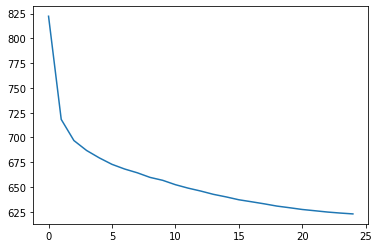

In [36]:
x_values = range(len(train_loss))
plt.plot(x_values, train_loss, label='Train_loss')

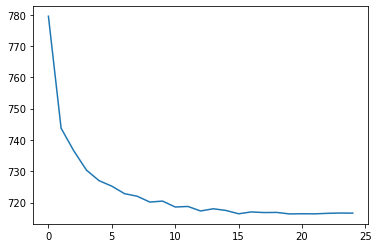

In [37]:
x_values_val = range(len(val_loss))
plt.plot(x_values_val, val_loss, label='val_loss')

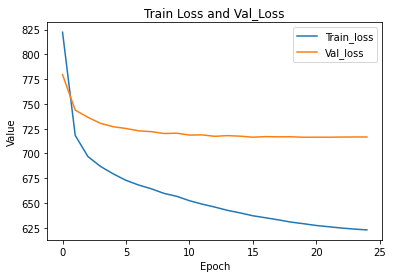

In [38]:
min_length = min(len(train_loss), len(val_loss))
list1 = train_loss[:min_length]
list2 = val_loss[:min_length]

# Create x-axis values
x_values = range(min_length)

# Plot the lists
plt.plot(x_values, list1, label='Train_loss')
plt.plot(x_values, list2, label='Val_loss')

# Adding labels and title
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Train Loss and Val_Loss')
plt.legend()